# Time Series EDA

- Time Series Train-Test Split
    1. Human-based
    1. Percentage Based
    1. Cross Validate Splits
- 10 Awesome Time Series Visualizations to Impress Your Friends and Family
    1. Blow off the time series
    1. y over time
    1. y averaged over various periods over time
    1. change in y over time
    1. Seasonal Plot
    1. Seasonal Subseries Plot
    1. Lag Plot
    1. Autocorrelation Plot
    1. Seasonal Decomposition
    1. Area Plots
- Aside: working with dates in matplotlib
- Aside: `strftime` ([Cheatsheet](https://zach.lol/strftime.html))

## Setup

We'll be looking at temperature data for san antonio from late 2012 to late 2017.

We'll need to convert from Kelvin to Fahrenheit.

°F = (K - 273.15) x 1.8000 + 32.00

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

# plotting defaults
plt.rc('figure', figsize=(11, 5))
plt.style.use('seaborn-whitegrid')
plt.rc('font', size=16)

url = 'https://gist.githubusercontent.com/ryanorsinger/0ec766c66f4089bdcbc1d4fb294a3394/raw/197c1f0d7b55a45f29437811bc73d9c4ef8af647/sa_temps.csv'
df = pd.read_csv(url, index_col='datetime', parse_dates=True).sort_index()
df.temp = (df.temp - 273.15) * 1.8 + 32

print('Date Range:', df.index.min(), 'to', df.index.max())
df.head()

df.shape[0]

Date Range: 2012-10-01 13:00:00 to 2017-11-30 00:00:00


45252

In [2]:
df.temp.describe()

count    45252.000000
mean        69.144163
std         14.946638
min         17.420000
25%         59.810000
50%         71.661650
75%         79.412000
max        104.918000
Name: temp, dtype: float64

- **seasonality**: a repeated cycle in the data. Occurs at a fixed frequency. In our weather data there is yearly and daily seasonality
- **trend**: long term upwards or downwards movement
- **cycle**: Some arbitrary chunk of time, usually longer than a season, or consists of multiple seasons

## Train-Test Split

- Ideally all splits contain a season
- Human-based: use the last year as test
- Percentage based: use the last 20% as test
- Cross Validate: break data up into slices and use successive slices as train and test repeatedly (`sklearn.model_selection.TimeSeriesSplit`)
    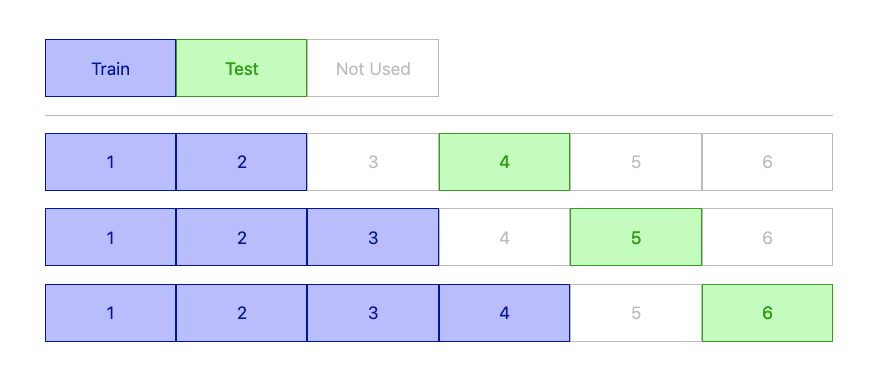

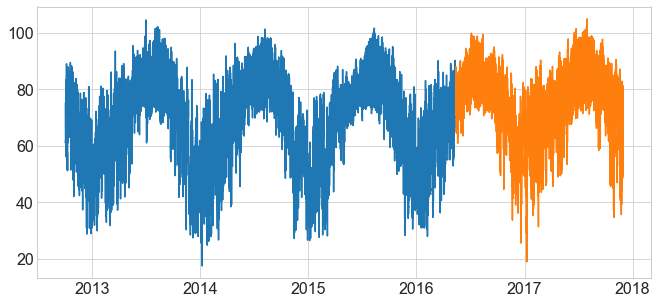

In [3]:
# Percentage-Based
train_size = .70
n = df.shape[0]
test_start_index = round(train_size * n)

train = df[:test_start_index] # everything up (not including) to the test_start_index
test = df[test_start_index:] # everything from the test_start_index to the end

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

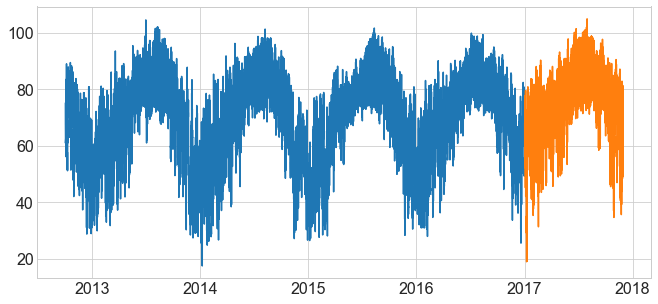

In [5]:
# Human-Based
train = df.loc[:'2016'] # includes 2016
test = df.loc['2017']

plt.plot(train.index, train.temp)
plt.plot(test.index, test.temp)

## Visualizations

In [6]:
y = train.temp
y.head()

datetime
2012-10-01 13:00:00    61.052000
2012-10-01 14:00:00    61.076568
2012-10-01 15:00:00    61.139294
2012-10-01 16:00:00    61.202020
2012-10-01 17:00:00    61.264747
Name: temp, dtype: float64

### 1 Blow off the time series

<AxesSubplot:ylabel='Frequency'>

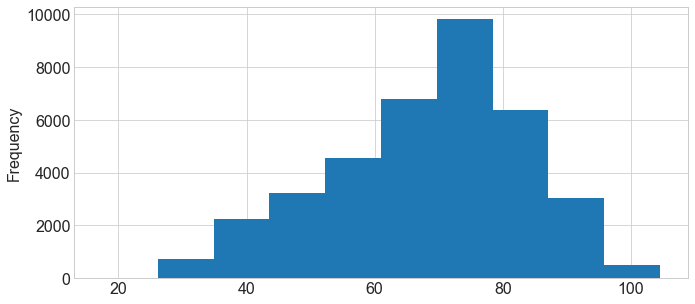

In [7]:
train.temp.plot.hist()

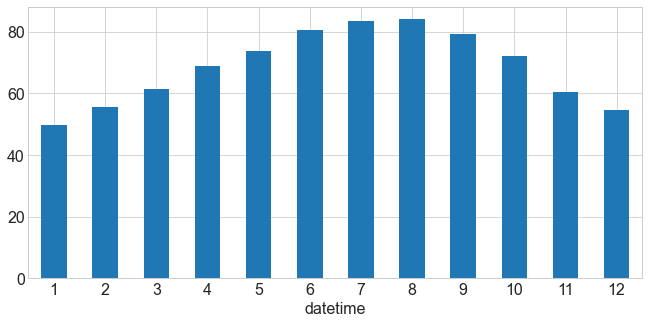

In [8]:
ax = train.groupby(train.index.month).temp.mean().plot.bar()
ax.tick_params('x', rotation=0)

/var/folders/5m/hv7mb0z95vnfhz0xb0s_rxym0000gn/T/ipykernel_56284/2166730346.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['weekday'] = train.index.day_name()


<AxesSubplot:xlabel='weekday'>

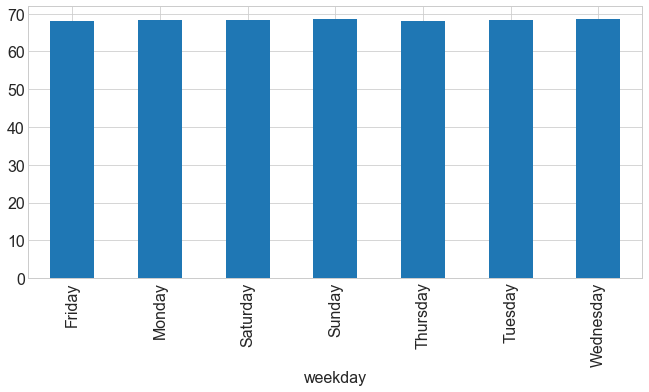

In [9]:
train['weekday'] = train.index.day_name()
train.groupby('weekday').temp.mean().plot.bar()

<AxesSubplot:xlabel='weekday', ylabel='temp'>

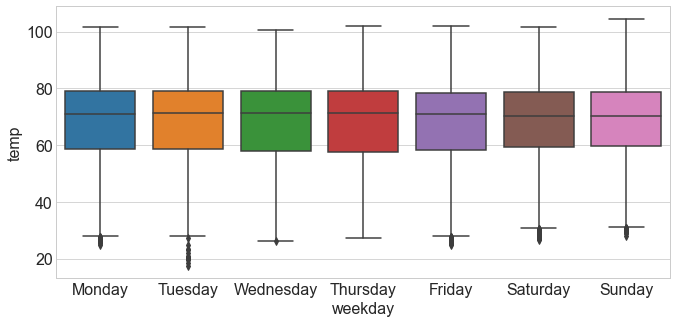

In [10]:
sns.boxplot(data=train, y='temp', x='weekday')

### 2 y over time

In [11]:
y.head()

datetime
2012-10-01 13:00:00    61.052000
2012-10-01 14:00:00    61.076568
2012-10-01 15:00:00    61.139294
2012-10-01 16:00:00    61.202020
2012-10-01 17:00:00    61.264747
Name: temp, dtype: float64

<AxesSubplot:xlabel='datetime'>

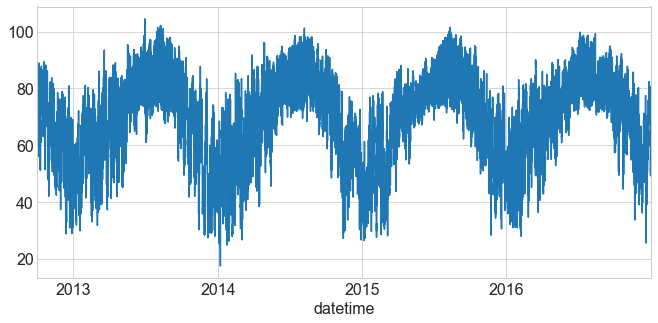

In [12]:
y.plot()

### 3 y averaged over various periods over time

<AxesSubplot:xlabel='datetime'>

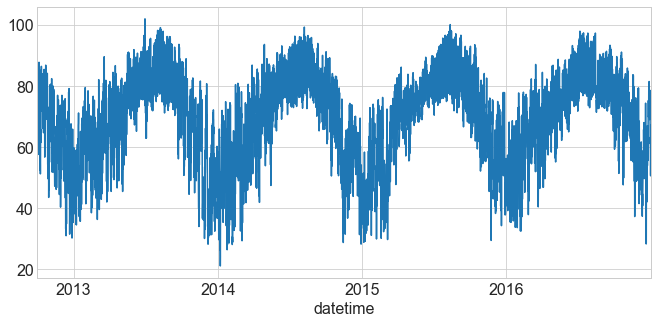

In [13]:
y.resample('6H').mean().plot()

<AxesSubplot:xlabel='datetime'>

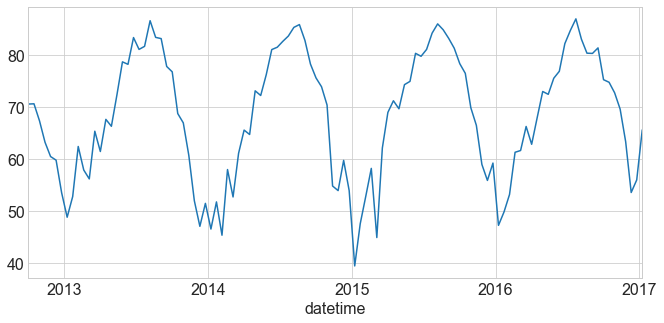

In [14]:
y.resample('2W').mean().plot()

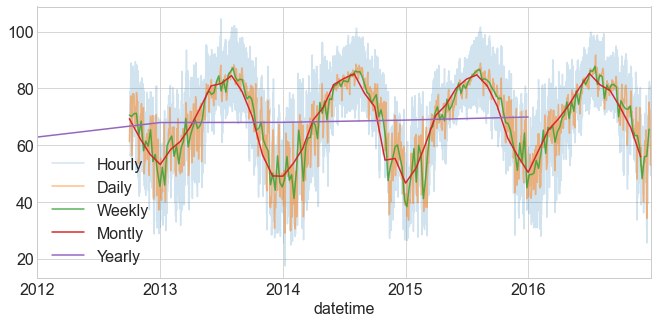

In [17]:
y.plot(alpha=.2, label='Hourly')
y.resample('D').mean().plot(alpha=.5, label='Daily')
y.resample('W').mean().plot(alpha=.8, label='Weekly')
y.resample('M').mean().plot(label='Montly')
y.resample('Y').mean().plot(label='Yearly')
plt.legend()

### 4 change in y over time

<AxesSubplot:xlabel='datetime'>

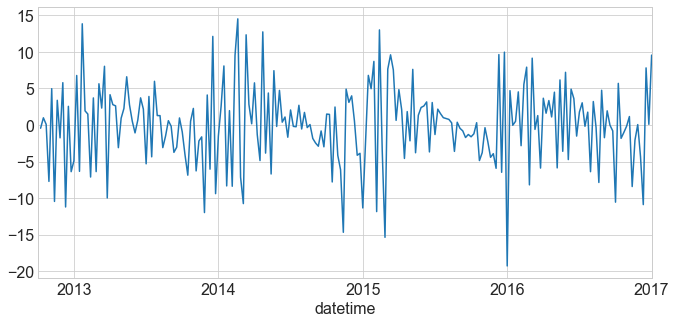

In [21]:
y.resample('W').mean().diff().plot()

[Text(0.5, 1.0, 'Temperature over time')]

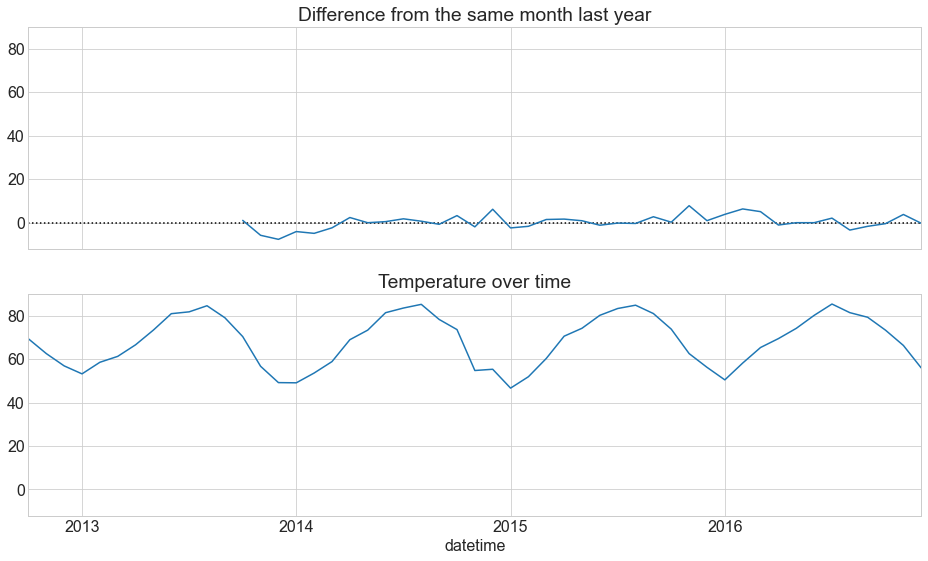

In [23]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(16, 9))

ax = y.resample('M').mean().diff(12).plot(ax=ax1)
ax1.hlines(0, *ax1.get_xlim(), color='black', ls=':')
ax1.set(title='Difference from the same month last year')

y.resample('M').mean().plot(ax=ax2)
ax2.set(title='Temperature over time')

### 5 Seasonal Plot

- xaxis: month 
- yaxis: y
- color: year

<AxesSubplot:title={'center':'Seasonal Plot'}, xlabel='datetime'>

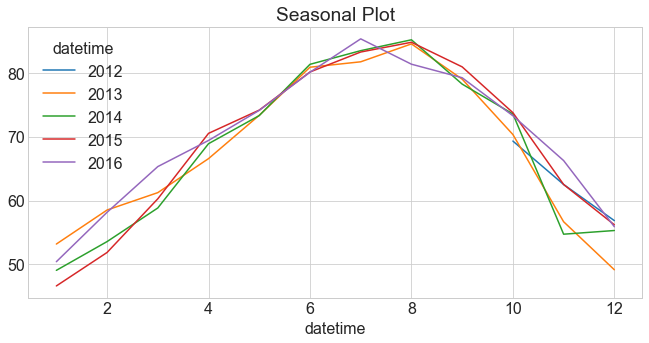

In [24]:
# .unstack turns an index level into columns
y.groupby([y.index.year, y.index.month]).mean().unstack(0).plot(title='Seasonal Plot')

### 6 Seasonal Subseries Plot

In [43]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()
table

datetime,1,2,3,4,5,6,7,8,9,10,11,12
datetime,,,,,,,,,,,,
2012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,69.318705,62.521575,56.860014
2013,53.192333,58.522799,61.244479,66.569717,73.358529,80.885728,81.731819,84.534117,79.016805,70.343832,56.686028,49.165310
2014,49.072897,53.579080,58.842459,68.908933,73.311970,81.337658,83.476876,85.178102,78.238621,73.567252,54.735951,55.311824
2015,46.631940,51.874683,60.277705,70.526879,74.169747,80.135967,83.264325,84.789859,80.938208,73.766466,62.519181,56.207118
2016,50.427347,58.165749,65.323011,69.415316,74.129780,80.097570,85.325640,81.357023,79.233476,73.284788,66.265047,55.903224


In [45]:
for month_number, subset in table.iteritems():
    print(month_number)

1
2
3
4
5
6
7
8
9
10
11
12


In [46]:
for number, letter in zip([1, 2, 3], ['a', 'b', 'c']):
    print(number, letter)

1 a
2 b
3 c


In [48]:
ax.get_xlim()

(2009.3215931784102, 2019.6784068215898)

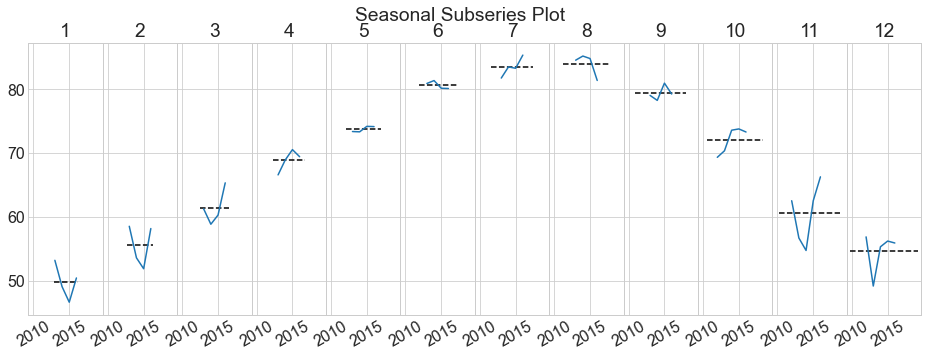

In [47]:
table = y.groupby([y.index.year, y.index.month]).mean().unstack()

fig, axs = plt.subplots(1, 12, sharey=True, sharex=True, figsize=(16, 5))

for ax, (month, subset) in zip(axs, table.iteritems()):
    subset.plot(ax=ax, title=month)
    ax.hlines(subset.mean(), *ax.get_xlim(), color='black', ls='--')
    ax.set(xlabel='')
    ax.tick_params('x', rotation=30)
    
fig.suptitle('Seasonal Subseries Plot') # super-title for the overall figure
# fig.tight_layout()
fig.subplots_adjust(wspace=0)

### 7 Lag Plot

In [52]:
train['y(t + 1)'] = train.temp.shift(-1)
train.head()

,temp,weekday,y(t + 1)
datetime,,,
2012-10-01 13:00:00,61.052000,Monday,61.076568
2012-10-01 14:00:00,61.076568,Monday,61.139294
2012-10-01 15:00:00,61.139294,Monday,61.202020
2012-10-01 16:00:00,61.202020,Monday,61.264747
2012-10-01 17:00:00,61.264747,Monday,61.327473


[Text(0.5, 0, 't'), Text(0, 0.5, 't + 1')]

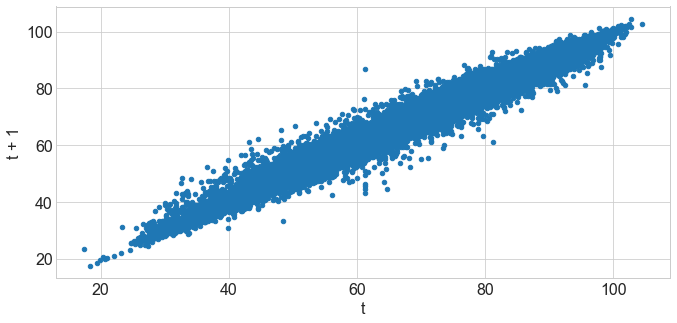

In [53]:
ax = train.plot.scatter(x='temp', y='y(t + 1)')
ax.set(xlabel='t', ylabel='t + 1')

,this_week,the_next_week
datetime,,
2012-10-07,70.595201,70.152821
2012-10-14,70.152821,71.138375
2012-10-21,71.138375,71.230464
2012-10-28,71.230464,63.510554
2012-11-04,63.510554,68.482625
...,...,...
2016-12-04,59.062094,48.163625
2016-12-11,48.163625,55.979132
2016-12-18,55.979132,56.073143


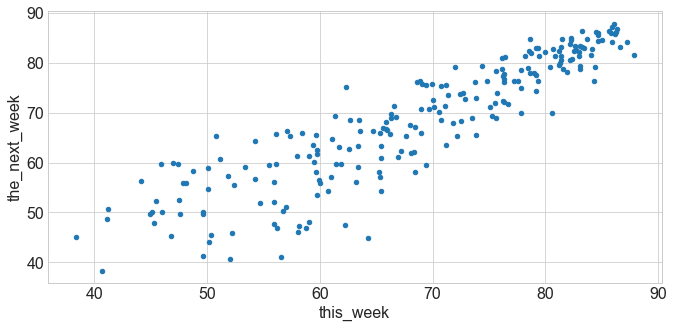

In [54]:
weekly = train.resample('W').mean().drop(columns='y(t + 1)')
weekly['the_next_week'] = weekly.temp.shift(-1)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='the_next_week')
weekly

<AxesSubplot:xlabel='this_week', ylabel='8_weeks_out'>

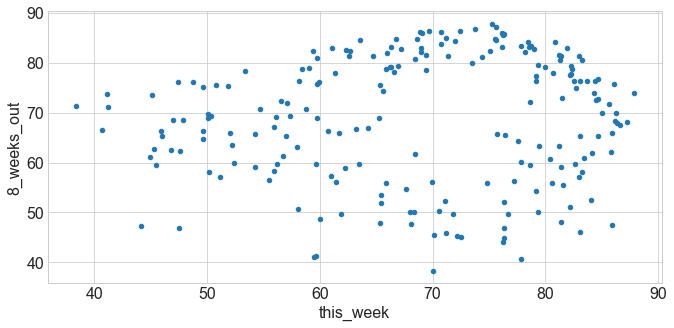

In [57]:
weekly = train.resample('W').mean().drop(columns='y(t + 1)')
weekly['8_weeks_out'] = weekly.temp.shift(-12)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='8_weeks_out')

,this_week,half_a_year_later
datetime,,
2012-10-07,70.595201,63.558611
2012-10-14,70.152821,66.345532
2012-10-21,71.138375,68.965502
2012-10-28,71.230464,65.862071
2012-11-04,63.510554,66.797107
...,...,...
2016-12-04,59.062094,NaN
2016-12-11,48.163625,NaN
2016-12-18,55.979132,NaN


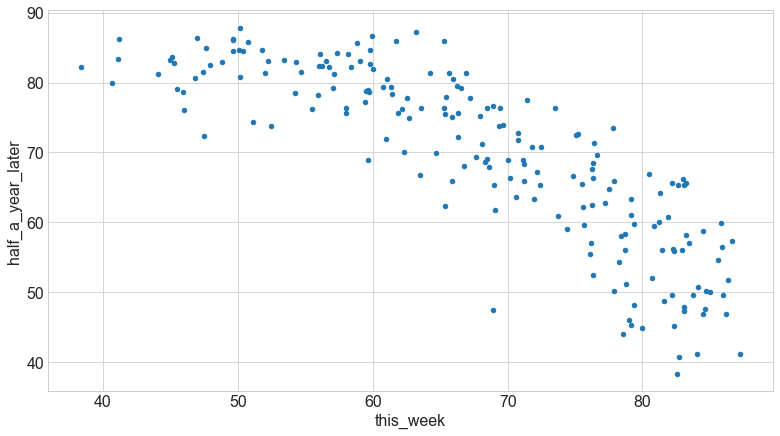

In [59]:
weekly = train.resample('W').mean().drop(columns='y(t + 1)')
weekly['half_a_year_later'] = weekly.temp.shift(-26)
weekly = weekly.rename(columns={'temp': 'this_week'})
weekly.plot.scatter(x='this_week', y='half_a_year_later', figsize=(13, 7))
weekly

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 52)'>

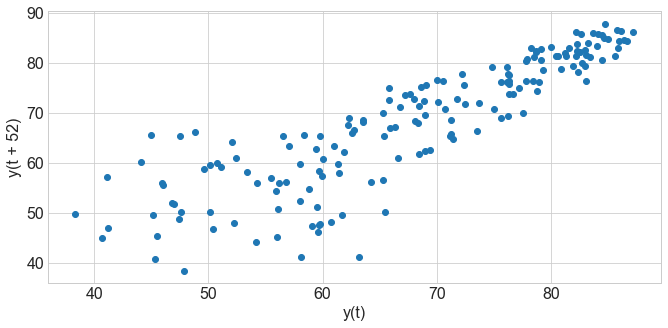

In [60]:
pd.plotting.lag_plot(train.temp.resample('W').mean(), lag=52)

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 156)'>

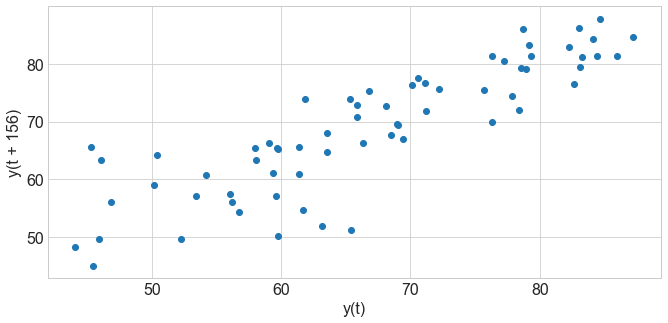

In [61]:
pd.plotting.lag_plot(train.temp.resample('W').mean(), lag=156) # 156 -- three years out

### 8 Autocorrelation Plot

- What is pearson's r as a function of the lag time?
- **autocorrelation**: a series correlation with itself
- can help to identify seasonality

In [64]:
from scipy import stats

In [69]:
lag = 1
weekly.temp.iloc[:-lag].shape, weekly.temp.shift(-lag).dropna().shape

((221,), (221,))

In [72]:
weekly = train.resample('W').mean()
s = pd.Series({
    lag: stats.pearsonr(
        weekly.temp.iloc[:-lag], weekly.temp.shift(-lag).dropna()
    )[0]
    for lag in range(1, 52*3 + 1)
})

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

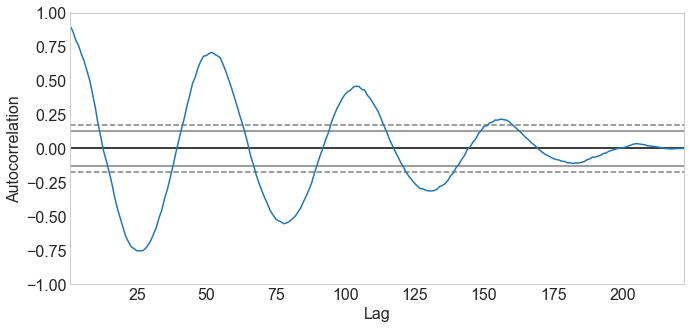

In [62]:
pd.plotting.autocorrelation_plot(train.temp.resample('W').mean())

### 9 Seasonal Decomposition

In [89]:
y = train.temp.resample('W').mean()

result = sm.tsa.seasonal_decompose(y)
decomposition = pd.DataFrame({
    'y': result.observed,
    'trend': result.trend,
    'seasonal': result.seasonal,
    'resid': result.resid,
})
decomposition['trend_centered'] = decomposition.trend - decomposition.trend.mean()

<AxesSubplot:xlabel='datetime'>

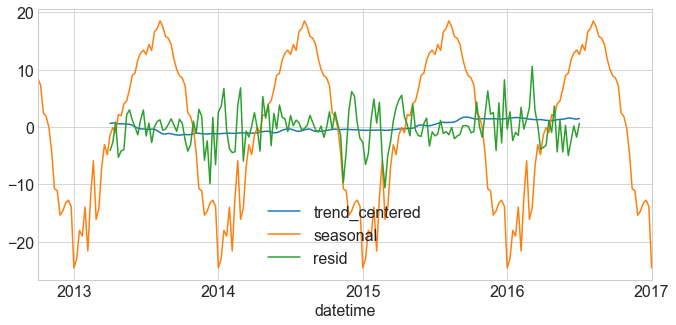

In [90]:
decomposition[['trend_centered', 'seasonal', 'resid']].plot()

<AxesSubplot:xlabel='datetime'>

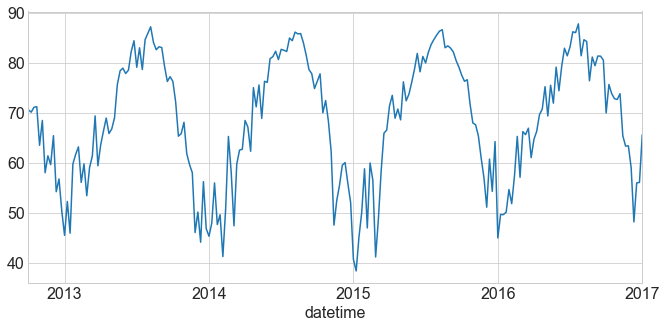

In [76]:
decomposition.y.plot()

Additive seasonal decomposition model:

$$ y_t = S_t + T_t + R_t $$

multiplicative model

$$ y_t = S_t \times T_t \times R_t $$

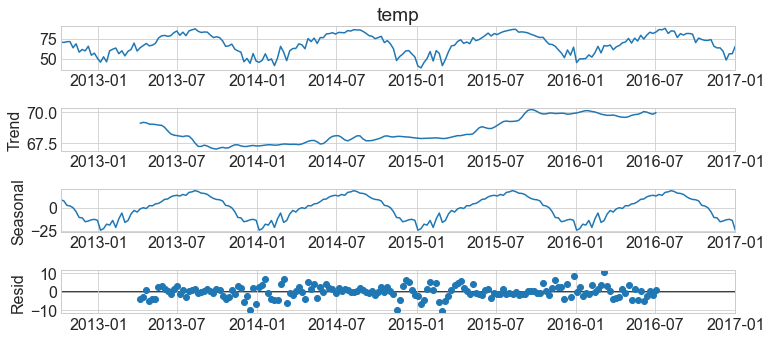

In [78]:
result.plot()
None

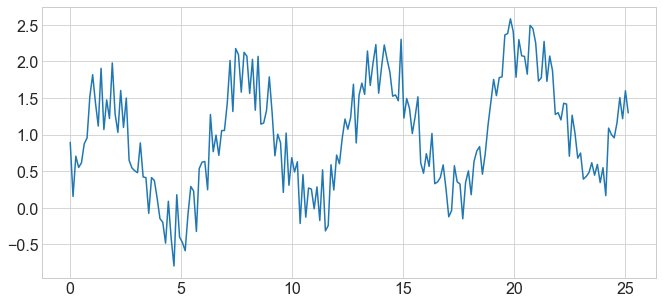

In [88]:
# Simulation Demo
import numpy as np

x = np.linspace(0, 8 * np.pi, 200)
seasonal = np.sin(x)
trend = np.linspace(0, 1, 200)
resid = np.random.rand(200)

y = seasonal + trend + resid

plt.plot(x, y)

### 10 Area Plots

- can we visualize categories over time?

In [91]:
train = train.drop(columns='y(t + 1)')

In [92]:
train = train.resample('D').mean()

In [131]:
train['temp_bin'] = pd.qcut(train.temp, 4, labels=['cold', 'cool', 'warm', 'hot'])

In [139]:
train.groupby('temp_bin').resample('M').size().unstack(-1)

datetime,2012-10-31,2012-11-30,2012-12-31,2013-01-31,2013-02-28,2013-03-31,2013-04-30,2013-05-31,2013-06-30,2013-07-31,...,2016-03-31,2016-04-30,2016-05-31,2016-06-30,2016-07-31,2016-08-31,2016-09-30,2016-10-31,2016-11-30,2016-12-31
temp_bin,,,,,,,,,,,,,,,,,,,,,
cold,6.0,10.0,16.0,24.0,17.0,11.0,7.0,1.0,0.0,0.0,...,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,21.0
cool,9.0,16.0,14.0,5.0,11.0,16.0,14.0,8.0,0.0,0.0,...,18.0,16.0,7.0,0.0,0.0,0.0,2.0,8.0,19.0,6.0
warm,16.0,4.0,1.0,2.0,0.0,4.0,9.0,16.0,12.0,9.0,...,8.0,13.0,21.0,11.0,3.0,10.0,10.0,18.0,7.0,4.0
hot,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,18.0,22.0,...,0.0,0.0,3.0,19.0,28.0,21.0,18.0,5.0,NaN,NaN


In [95]:
train.groupby('temp_bin').mean()

,temp
temp_bin,
cold,49.381699
cool,65.200219
warm,75.447977
hot,83.449087


How is the distribution of temp_bin changing over time?

In [105]:
table = train.groupby('temp_bin').resample('M').size().unstack(0)
table.apply(lambda row: row / row.sum(), axis=1)

temp_bin,cold,cool,warm,hot
datetime,,,,
2012-10-31,0.193548,0.290323,0.516129,NaN
2012-11-30,0.333333,0.533333,0.133333,NaN
2012-12-31,0.516129,0.451613,0.032258,NaN
2013-01-31,0.774194,0.161290,0.064516,NaN
2013-02-28,0.607143,0.392857,0.000000,NaN
2013-03-31,0.354839,0.516129,0.129032,NaN
2013-04-30,0.233333,0.466667,0.300000,NaN
2013-05-31,0.032258,0.258065,0.516129,0.193548
2013-06-30,0.000000,0.000000,0.400000,0.600000


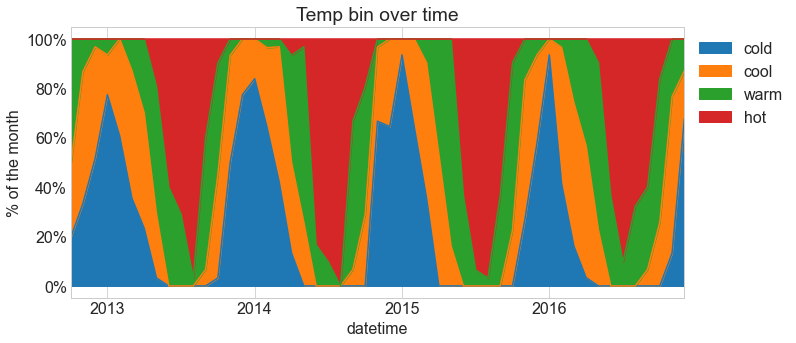

In [110]:
ax = (train.groupby('temp_bin')
 .resample('M')
 .size()
 .unstack(0)
 .apply(lambda row: row / row.sum(), axis=1)
 .plot.area(title='Temp bin over time', ylabel='% of the month'))
ax.legend(loc="upper left", bbox_to_anchor=(1, 1))
ax.yaxis.set_major_formatter('{:.0%}'.format)

## `strftime`

[Cheatsheet](https://zgulde.net/strftime.html) or `man strftime`

In [111]:
train.index.strftime('%w-%A')

Index(['1-Monday', '2-Tuesday', '3-Wednesday', '4-Thursday', '5-Friday',
       '6-Saturday', '0-Sunday', '1-Monday', '2-Tuesday', '3-Wednesday',
       ...
       '4-Thursday', '5-Friday', '6-Saturday', '0-Sunday', '1-Monday',
       '2-Tuesday', '3-Wednesday', '4-Thursday', '5-Friday', '6-Saturday'],
      dtype='object', name='datetime', length=1553)

In [112]:
df.head(5).index.strftime('The date is %B %d, %Y and the time is %I:%M %p')

Index(['The date is October 01, 2012 and the time is 01:00 PM',
       'The date is October 01, 2012 and the time is 02:00 PM',
       'The date is October 01, 2012 and the time is 03:00 PM',
       'The date is October 01, 2012 and the time is 04:00 PM',
       'The date is October 01, 2012 and the time is 05:00 PM'],
      dtype='object', name='datetime')

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

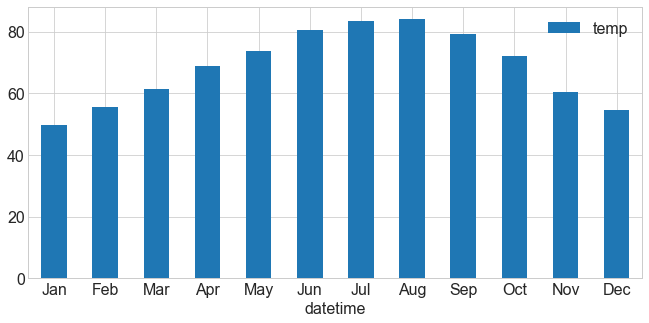

In [115]:
ax = train.groupby(train.index.strftime('%m-%b')).mean().plot.bar()
ax.set_xticklabels([t.get_text()[3:] for t in ax.get_xticklabels()], rotation=0)

See also: pd.Categorical

<AxesSubplot:xlabel='weekday'>

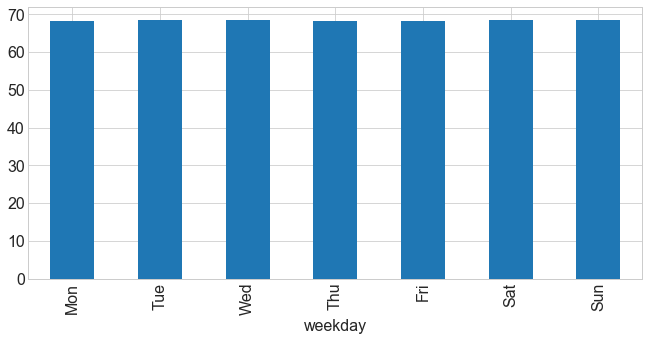

In [121]:
train['weekday'] = train.index.strftime('%a')
train.weekday = pd.Categorical(train.weekday, categories=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'], ordered=True)
train.groupby('weekday').temp.mean().plot.bar()

## Matplotlib Dates

In [123]:
from matplotlib.dates import DateFormatter, MonthLocator

In [126]:
weekly = df.temp.resample('W').mean()

<AxesSubplot:xlabel='datetime'>

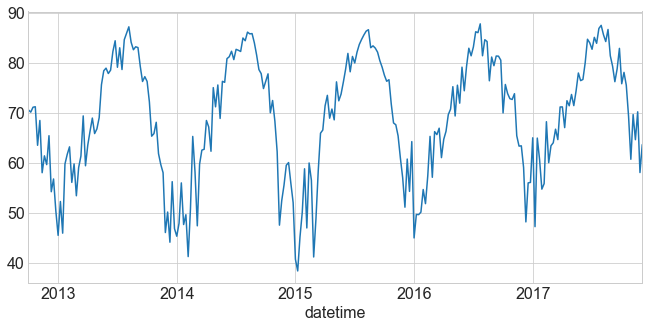

In [127]:
weekly.plot()

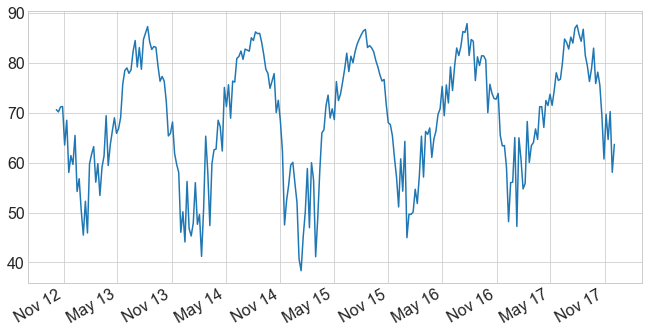

In [130]:
fig, ax = plt.subplots()

x = weekly.index
y = weekly.values

ax.plot(x, y)

ax.xaxis.set_major_formatter(DateFormatter('%b %y'))
ax.xaxis.set_major_locator(MonthLocator(interval=6))

ax.tick_params(axis='x', rotation=30)

for tick in ax.xaxis.get_majorticklabels():
    tick.set_ha('right')

## Additional Questions

- breakdown seasonal subseries